# **📈 Predicting StockX Sneaker Prices using SageMaker DeepAR**
---

## **Contents**

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Predictions](#Predictions)

---

## **Background**
This notebook demonstrates time series forecasting using the Amazon SageMaker DeepAR alogrithm by analyzing Stockx sneaker prices.  


<span style="color:red; font-weight: bold">Disclaimer</span> : Please note that I am a newbie to AI/ML. I built this project so I can further my own learning in Machine Learning. I am sharing it because I hope it can assist someone who is also on a similar journey as I am. 

---

## **Setup** 
This notebook was created and tested on a ml.m4.xlarge instance. 



### Enable Kaggle Tools 

What is Kaggle? Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges. You can find out more about Kaggle on their [website](https://www.kaggle.com/). 

We will be using Kaggle to download the Stockx sneaker sales dataset.

In [2]:
!pip install --q kaggle 

Keyring is skipped due to an exception: 'keyring.backends'


To use Kaggle API, you must have an account and an API token. You can register for a Kaggle account [here](https://www.kaggle.com/docs/api) and generate your API token, it is completely free. 

In [3]:
!touch ~/.kaggle/kaggle.json # Creates json file to store Kaggle API Credentials
kaggle_api_token = {"username":"gilbertyoungjr","key":"9c1e0b76bd43718e8bf816ac26e05824"}  # Insert your own username and API Key here

In [4]:
import json 

# Writes API Credentials to Kaggle file
with open('/root/.kaggle/kaggle.json', 'w') as file: 
    json.dump(kaggle_api_token,file)
    

For security reasons, we must ensure that other users of our computer do not have read access to our Kaggle credentials.

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

### Import Packages

In [6]:
import sagemaker
import boto3
import io
import json
import time
from datetime import timedelta
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import s3fs


Let's start by specifying:

1. The S3 Bucket that will be used for training and model data
1. IAM arn used to give training and hosting access to the data See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace sagemaker.get_execution_role() with the appropriate full IAM role arn string(s).

In [7]:
sagemaker_session = sagemaker.Session() # Use to interact with SageMaker services
s3_bucket = sagemaker_session.default_bucket() # Return the name of the default bucket to use for SageMaker interactions.
s3_prefix = "stockx_sneaker_prices"  # Change to your desired S3 prefix
region = sagemaker_session.boto_region_name # Sets default region for SageMaker

# Defines data path to store files 
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)
role = sagemaker.get_execution_role() # Return IAM Role used by SageMaker 


Next, we configure the container image to be used for the region that we are running in.

In [8]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region) # Defines which alogrithm to use

---
## **Data** 
The dataset used in this project, is from the [StockX 2019 Data Contest](https://www.kaggle.com/datasets/hudsonstuck/stockx-data-contest).

The data consists of a random sample of all Off-White x Nike and Yeezy 350 sales from between 9/1/2017 (the month that Off-White first debuted “The Ten” collection) and the present. There are 99,956 total sales in the data set; 27,794 Off-White sales, and 72,162 Yeezy sales. The sample consists of U.S. sales only.

In [9]:
#!kaggle datasets list # List available datasets
!kaggle datasets download -d hudsonstuck/stockx-data-contest --unzip # Downloads & Unzip dataset

  0%|                                                | 0.00/711k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 711k/711k [00:00<00:00, 9.45MB/s]


Now that the dataset is downloaded, let us visualize what the data looks like. 

In [10]:
initial_data = pd.read_csv('StockX-Data-Contest-2019-3.csv', header = 0, parse_dates=['Order Date', 'Release Date'])
df = initial_data.copy()
df.head() # Display first 5 rows

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2017-02-11,11.0,Rhode Island


### Data Cleaning 
The data is already somewhat nicely formatted for us, but there are still a few cleaning we have to do. 

1. Remove dashes ('-') from Sneaker Name 
1. Remove dollar sign ('$') and comma (',') from prices (Sales Price, Retail Price) and covert data type to float
1. Rename columns 
1. Lastly, we will only look at the top 10 sneakers in the dataset

In [11]:
# Remove dashes ('-') from Sneaker Name 
df['Sneaker Name'] = df['Sneaker Name'].apply(lambda x: x.replace('-', ' '))

In [12]:
# Remove dollar sign ('$') and comma (',') from prices (Sales Price, Retail Price) 
# Converts values to type float64
df['Sale Price'] = df['Sale Price'].apply(lambda x: x.replace('$', ''))
df['Sale Price'] = df['Sale Price'].apply(lambda x: x.replace(',', ''))
df['Sale Price'] = df['Sale Price'].astype(float)
df['Retail Price'] = df['Retail Price'].apply(lambda x: x.replace('$', ''))
df['Retail Price'] = df['Retail Price'].apply(lambda x: x.replace(',', ''))
df['Retail Price'] = df['Retail Price'].astype(float)

In [13]:
# Renaming columns to remove spaces 
df = df.rename(columns={
    "Order Date": "order_date",
    "Brand": "brand",
    "Sneaker Name": "sneaker_name",
    "Sale Price": "sale_price",
    "Retail Price": "retail_price",
    "Release Date": "release_date",
    "Shoe Size": "shoe_size",
    "Buyer Region": "buyer_region"
    })

In [14]:
# Convert Categorical Values to numeric
top_sneakers = df['sneaker_name'].value_counts().head(10).index
top_brand = df['brand'].value_counts().head(2).index
formatted_sneaker = []

# format sneaker name to match values after one hot encoding
for row in top_sneakers: 
    row = f'sneaker_name_{row}'
    formatted_sneaker.append(row)
    
# perform one hot encoding     
clean_data = pd.get_dummies(df, columns=['sneaker_name', 'brand'])

### Visualization of Data
Now that the data is perfeclty formatted, we can illustrate the insights below. 

1. Average Daily Sales 

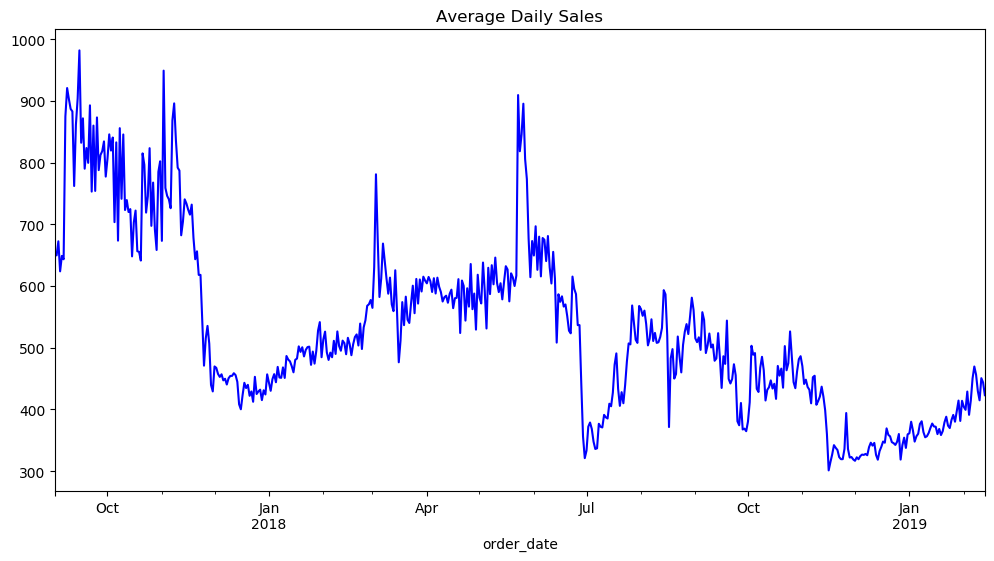

In [15]:
daily_sales = df.resample('D', on='order_date')['sale_price'].mean()

plt.figure(figsize=(12,6))
daily_sales.plot(title='Average Daily Sales', color='blue')
plt.show()

### Train & Test Splits

Before we can run the DeepAR algorithm, we need to do one final prepartion, split data by time series for training and test and lastly
converting the data frames to JSON format. DeepAR expects input training data to be JSON fields.
You can see more on their [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html)

We specify what section of the data is used for model training: the model sees data from 2017-09-01 to 2018-07-01.

In [16]:
# Using daily frequency
freq = "D"

# we predict for 5 days
prediction_length = 5

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 5

# Defines start and stop for timeseries in dataset
start_dataset = pd.Timestamp("2017-09-01 00:00:00", freq)
end_training = pd.Timestamp("2018-07-01 00:00:00", freq)

clean_data.set_index('order_date', inplace=True) # Sets column index on order date 

training_data = []
test_data = []

for idx, row in enumerate(formatted_sneaker):
    data = clean_data[clean_data[row] == 1] # Filter to get data only where sneaker name matches
    training_data.append({"start": str(start_dataset), 
                          "target": data[start_dataset : end_training - timedelta(days=1)].sale_price.values.tolist(),
                          "cat": [idx] })
    test_data.append({"start": str(start_dataset), 
                          "target": data[start_dataset : end_training - timedelta(days=1 * prediction_length)].sale_price.values.tolist(),
                          "cat": [idx] })
    
    

#training_data = [{"start": str(start_dataset), "target": clean_data[start_dataset : end_training - timedelta(days=1)].sale_price.values.tolist()}]
#test_data = [{"start": str(start_dataset), "target": clean_data[start_dataset : end_training + timedelta(days=1 * prediction_length)].sale_price.values.tolist()}]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  if sys.path[0] == '':


Now lets write the dictionary to JSON files so DeepAR can comprehend the dataset.

In [17]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [18]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 12.3 ms, sys: 1.27 ms, total: 13.6 ms
Wall time: 94.4 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. 
Depending on your network connection, this may take a couple of minutes.

In [19]:
s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [20]:
%%time

copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

File s3://sagemaker-us-east-1-155047035098/s3://sagemaker-us-east-1-155047035098/stockx_sneaker_prices/data/train/train.json already exists.
Set override to upload anyway.

File s3://sagemaker-us-east-1-155047035098/s3://sagemaker-us-east-1-155047035098/stockx_sneaker_prices/data/test/test.json already exists.
Set override to upload anyway.

CPU times: user 18.4 ms, sys: 14.5 ms, total: 32.8 ms
Wall time: 111 ms


Let’s have a look to what we just wrote to S3.

In [21]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2017-09-01 00:00:00", "target": [600.0, 400.0, 450.0, 500.0, 459.0, 419.0, 385.0, 430.0, ...


---
## **Train**

Now that we are completed with data cleaning and processing, we can get to the fun part to train the model and predict results.

In [22]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type="ml.c4.2xlarge",
    base_job_name="stockx-sneaker-prices",
    output_path=s3_output_path,
)

Next we define our hyperparameters for the model to use.

In [23]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "500",
    "early_stopping_patience": "10",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [24]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the test data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last prediction_length points of each time-series in the test set and comparing this to the actual value of the time-series.

Note: the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [25]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

2022-11-29 22:53:33 Starting - Starting the training job...
2022-11-29 22:53:57 Starting - Preparing the instances for trainingProfilerReport-1669762413: InProgress
......
2022-11-29 22:54:57 Downloading - Downloading input data...
2022-11-29 22:55:17 Training - Downloading the training image........Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[11/29/2022 22:56:43 INFO 140247772182336] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_obje

---
## Predictions

Now that the model has been trained, we can leverage it to perform predictions by deploying it to an endpoint

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using pandas.Series objects rather than raw JSON strings.

In [26]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    # serializer=JSONSerializer(),
    deserializer= JSONDeserializer()
)

---------!

In [28]:
def to_json_predictor_input(ts_list, num_samples=1, quantiles=['0.1', '0.5', '0.9']):
    instances = []
    for i in range(len(ts_list)):
        instances.append({
            'start': str(ts_list[i]['start']),
            'target': list(ts_list[i]['target']),
            'cat': list(ts_list[i]['cat']),
        })

    configuration = {
        'output_types': ["mean", "quantiles", "samples"],
        'num_samples': num_samples,
        'quantiles': quantiles
    }

    json_request = json.dumps({
        'instances': instances,
        'configuration': configuration
    })
   

    return json_request




# Define testing data
release_date = pd.Timestamp("2022-09-01 00:00:00", freq)
testing_data = [{"start": str(release_date), "target": [400], "cat": [4]}]
print(to_json_predictor_input(testing_data))

prediction = predictor.predict(to_json_predictor_input(testing_data), initial_args={'ContentType': 'application/json'})

print(prediction)

{"instances": [{"start": "2022-09-01 00:00:00", "target": [400], "cat": [4]}], "configuration": {"output_types": ["mean", "quantiles", "samples"], "num_samples": 1, "quantiles": ["0.1", "0.5", "0.9"]}}
{'predictions': [{'mean': [301.6378479004, 325.6867980957, 365.9208068848, 414.7009277344, 306.066986084], 'quantiles': {'0.1': [301.6378479004, 325.6867980957, 365.9208068848, 414.7009277344, 306.066986084], '0.5': [301.6378479004, 325.6867980957, 365.9208068848, 414.7009277344, 306.066986084], '0.9': [301.6378479004, 325.6867980957, 365.9208068848, 414.7009277344, 306.066986084]}, 'samples': [[301.6378479004, 325.6867980957, 365.9208068848, 414.7009277344, 306.066986084]]}]}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.


In [58]:


predictor.delete_model()
predictor.delete_endpoint()
